In [1]:
!pip install hexfft==0.1.4

# Basic filtering



## Rectangularly periodic signal

First we'll try a simple Gaussian blur filter. Let's used a rectangular 2D box signal as our input.

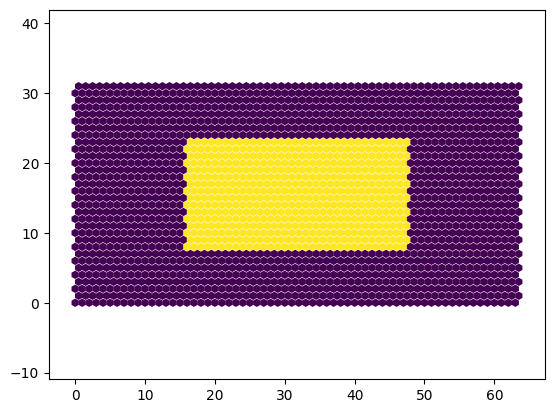

In [2]:
from hexfft import HexArray, fft, ifft
from hexfft.plot import hexshow
import numpy as np

N1, N2 = 32, 64

# create input signal
s = HexArray(np.zeros((N1, N2)))
s[N1//4 : 3*N1//4, N2//4 : 3*N2//4] = 1.

hexshow(s)

Now we'll create the Gaussian filter kernel. We'll go with a rough approximation to a Gaussian, which has a peak of 1 at the center, decreases to 0.5 in the nearest neighbors of the center, and is zero elsewhere.

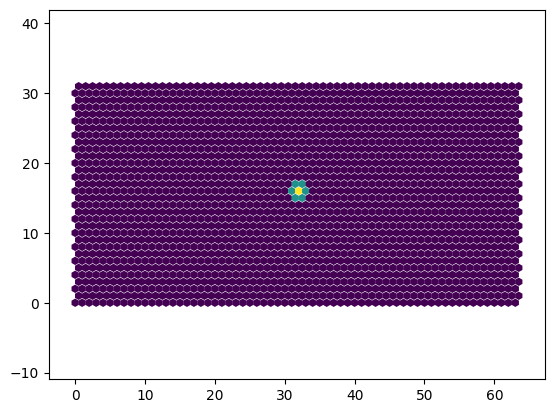

In [3]:
kernel = HexArray(np.zeros((N1, N2)))
kernel[N1//2, N2//2] = 1.

# nearest neighbors of the center pixel in *offset* coordinates
c1, c2 = N1//2, N2//2
idx = np.array([[c1, c2-1], [c1, c2+1], [c1-1, c2], [c1+1, c2], [c1-1, c2-1], [c1+1, c2-1]])
kernel[tuple(idx.T)] = 0.5

hexshow(kernel)

To perform a hexagonal convolution of the input image with this kernel, we can take the Fourier transform of both, multiple them, and then take the inverse Fourier transform to recover the filtered image.

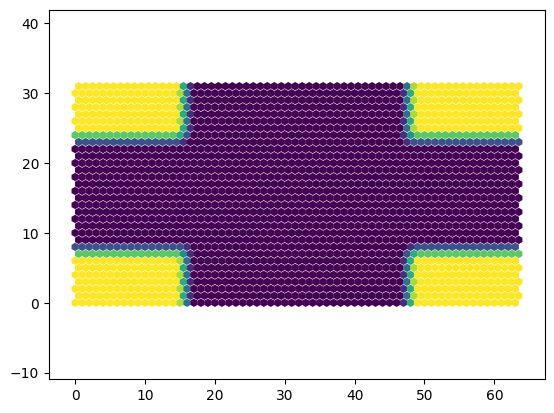

In [4]:
from hexfft import fft, ifft

S = fft(s)
K = fft(kernel)

# perform convolution by pointwise multiplication in frequency space
FILT = S * K

filt = ifft(FILT)
hexshow(np.real(filt))

There's a problem though. The input signal has been filtered, but when we took the IFFT, the quadrants of the grid seem to be scrambled. From another perspective, our "viewing window" of the rectangularly periodic signal has been shifted.

This is because we defined our kernel at an offset relative to the origin. We can correct this using the `filter_shift` method.

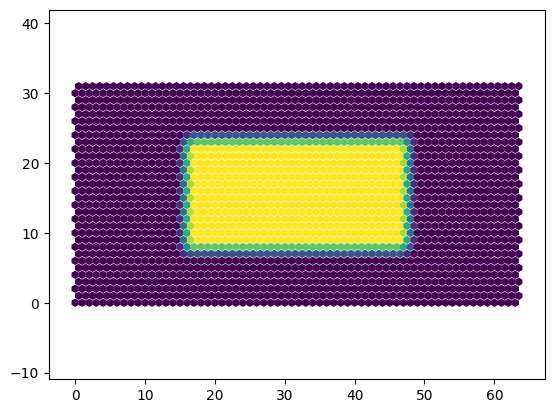

In [5]:
from hexfft.utils import filter_shift
hexshow(filter_shift(np.real(filt)))

Alternatively, we could have shifted the kernel itself using the same method before performing the convolution in Fourier space.

## Hexagonally periodic signal

For a signal defined on a hexagonal region, the process is much the same. We just need to use the `"hex"` option in the FFT to account for the different periodicity. We'll use a simple hexagonal "box" function as an example again. Here I am borrowing a function from the `hexfft` tests to create a customizable hexagon on the grid.

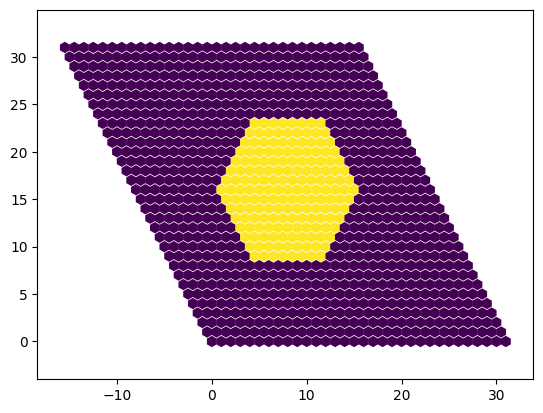

In [6]:
from hexfft.array import generate_indices

def hregion(n1, n2, center, size):
    """
    return mask for a hexagonal region of support
    with side length size centered at center
    """
    h1, h2 = center
    A = n2 < h2 + size
    B = n2 > h2 - size
    C = n1 > h1 - size
    D = n1 < h2 + size
    E = n2 < n1 + (h2 - h1) + size
    F = n2 > n1 + (h2 - h1) - size
    cond = A & B & C & D & E & F
    return HexArray(cond.astype(int), "oblique")

N = 32
n1, n2 = generate_indices((N, N), "oblique")

h = hregion(n1, n2, (N//2, N//2), N//4)

hexshow(h)

This time we'll try a very basic Laplacian filter. We expect this filter to bring out the sharp contrasts in the image. In this case, we hope to detect the edges of the hexagon.

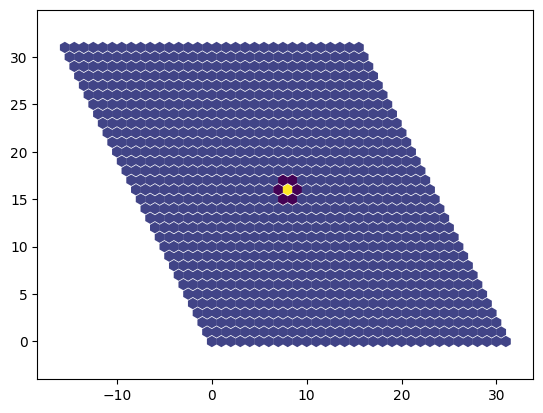

In [7]:
kernel = HexArray(np.zeros((N, N)), "oblique")
kernel[N//2, N//2] = 4
c = N//2

# Note that for the oblique array, finding the six nearest neighbor points
# of the center is slightly different.
idx = np.array([[c, c-1], [c, c+1], [c-1, c], [c+1, c], [c-1, c-1], [c+1, c+1]])
kernel[tuple(idx.T)] = -1

hexshow(kernel)


As before we take the Fourier transform of both. Note the tri-fold symmetry of the transforms.

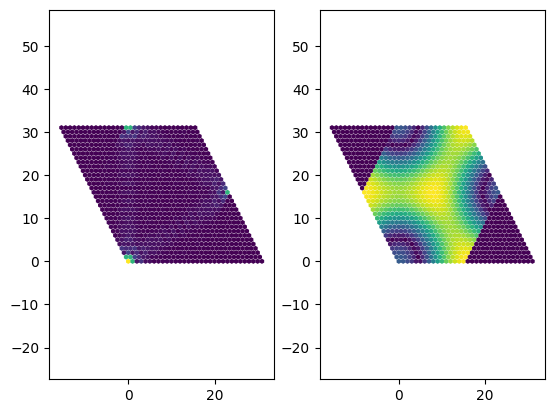

In [8]:
H = fft(h, "hex")
K = fft(kernel, "hex")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)
hexshow(np.abs(H), ax=ax[0])
hexshow(np.abs(K), ax=ax[1])

Perform the pointwise multiplication in Fourier space as before.

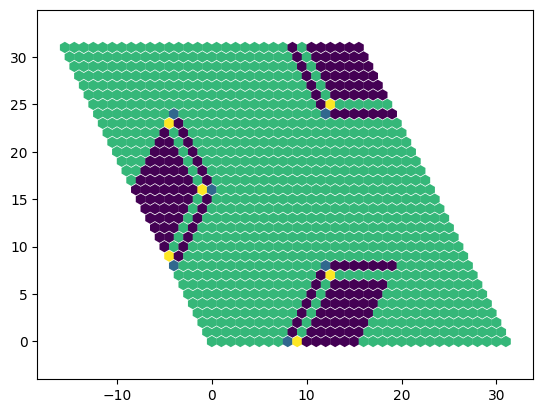

In [9]:
FILT = H * K
filt = ifft(FILT, "hex")
hexshow(np.real(filt))

Oh no! We seem to have the same problem as when we used the rectangular region of support. This time, the thirds of the image have been shifted to different corners of the hexagonal region of support. We can once again use `filter_shift`, but with the `"hex"` argument to let the function know we are operating on a hexagonal rather than rectangular region support.

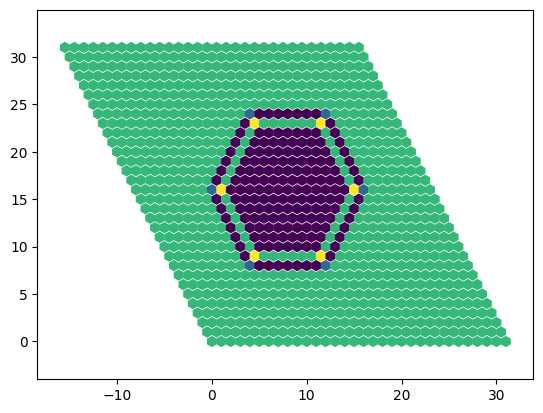

In [11]:
hexshow(filter_shift(np.real(filt), "hex"))

Now we have our filtered image. It is clear that our filter has brought out the edges of the hexagonal shape, but not in a way where it would be easy to programmatically detect the edges.

The design of discrete hexagonal filters is an open area of research.